neccessary imports, setting the compute device, setting seed, loading the network and scalers

In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import random
import torch 
import pickle
import optuna 

## user inputs ## 
# names and directories 
model_name = "forward_MLP.pth" 
scaler_model_dir_name = "network_data"  
input_scaler_filename = "input_scaler.pkl" 
state_scaler_filename = "state_scaler.pkl"
# neural network configuration  
lag_input = 0 
lag_state = 1
num_hidden_layers = 0
hidden_units = 30 
input_flat_size = 6 + (lag_state*6) + 3 + (lag_input*3) 
output_size = 6 
# optimization parameters 
x_intial = np.array([3.3065416622541037e-06, 0, -0.19036912150652113, 6.0826336879046396e-06, 0, -0.3907576704717413])
X = np.vstack([x_intial, x_intial]) 
u_initial = np.array([0,0,0]) 
U = u_initial
delta_umax = 12 
umax = 12 
tmax = 3  
dt = 0.1 # sampling time
z_g = -1 # structure height 
g = 9.8 # gravity acceleration
des_land_pos = [0.15, 0.15] # desired landing pose 
Q = 1 # landing pose weight term  
n_trials = 1000 # number of trials

# selecting the compute device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"using compute device: {device}") 
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")   

# setting seeds 
def set_all_seeds(seed: int = 42):
    """
    sets the seeds for python, numpy, and pytoch (CPU & GPU) 
    """
    # python random module
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    # pytorch (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed}") 

# defining the model 
class MLP_model(torch.nn.Module): 
    def __init__(self, input_flat_size:int, hidden_units:int, output_size:int, num_hidden_layers:int) :
        super().__init__()
        self.input_flat_size = input_flat_size 
        self.hidden_units = hidden_units 
        self.output_size = output_size 
        self.num_hidden_layers = num_hidden_layers 

        hidden_layers = [] 

        in_dimension = self.input_flat_size 

        self.input_layer = torch.nn.Linear(in_features=in_dimension, out_features=self.hidden_units) 
        
        for i in range(self.num_hidden_layers) : 
            hidden_layers.append(torch.nn.Linear(in_features=self.hidden_units, out_features=self.hidden_units)) 
            hidden_layers.append(torch.nn.ReLU()) 

        self.backbone = torch.nn.Sequential(*hidden_layers) 
        
        self.output_layer = torch.nn.Linear(in_features=self.hidden_units, out_features=self.output_size) 
 
        self.relu = torch.nn.ReLU()    

    def forward(self,x): 
        out = self.input_layer(x) 
        out = self.relu(out)
        out = self.backbone(out)  
        out = self.output_layer(out) 
        return out  

# instantiating an NN object 
forward_model = MLP_model(input_flat_size=input_flat_size, hidden_units=hidden_units, output_size=output_size, num_hidden_layers=num_hidden_layers) 

# loading the statedicts 
script_path = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd() 
model_data_path = os.path.join(script_path, scaler_model_dir_name) 
forward_model.load_state_dict(torch.load(os.path.join(model_data_path, model_name), weights_only=True)) 
forward_model = forward_model.to(device=device) 
forward_model.eval()  

# loading the scalers 
with open(os.path.join(model_data_path, input_scaler_filename), "rb") as file : 
    input_scaler = pickle.load(file) 
with open(os.path.join(model_data_path, state_scaler_filename), "rb") as file : 
    state_scaler = pickle.load(file)

using compute device: cpu


defining the objective function

In [20]:
def objective(trial) : 
    # defining the decision variables 
    u1_step = trial.suggest_float("act1_step", 0, umax) # actuator 1 
    u2_step = trial.suggest_float("act2_step", 0, umax) # actuator 2
    u3_step = trial.suggest_float("act3_step", 0, umax) # actuator 3 
    u_step = np.array([u1_step, u2_step, u3_step]) # shape (,3)
    # smoothstep and release time  
    t_smoothstep = trial.suggest_float("t_smoothstep", 0, tmax) 
    t_release = trial.suggest_float("t_release", 0, t_smoothstep) 
    
    '''
    # generating the input array based on the smoothstep and sampling time 
      
    ramp_steps = round(t_smoothstep/dt) 
    release_steps = round(t_release/dt) 
    smoothstep_factor = np.zeros((ramp_steps,3)) # shape (ramp_steps, 3) 
    ''' 

    # --- FIXED SECTION START ---
    
    # 1. Define the total simulation steps based on tmax (e.g., 30 steps for 3s)
    total_steps = int(tmax / dt)
    
    # 2. Calculate ramp steps, ensuring at least 1 step to avoid errors
    ramp_steps = round(t_smoothstep / dt)
    if ramp_steps < 1:
        ramp_steps = 1
    
    release_steps = round(t_release/dt)
        
    # 3. Create the smoothstep ramp profile
    smoothstep_factor = np.zeros((ramp_steps, 3))
    for i in range(ramp_steps):
        # Prevent division by zero if ramp_steps is 1
        if ramp_steps > 1:
            x_val = (i - 0) / ((ramp_steps - 1) - 0)
        else:
            x_val = 1.0 # Instant step
        smoothstep_factor[i, :] = x_val * x_val * (3 - 2 * x_val)
        
    u_ramp = smoothstep_factor * u_step
    
    # 4. Pad the rest of the simulation with the final input value (Hold)
    hold_steps = total_steps - ramp_steps
    
    if hold_steps > 0:
        # Repeat the final input command for the duration of the hold
        u_hold = np.tile(u_step, (hold_steps, 1)) 
        u_array = np.vstack((u_ramp, u_hold))
    else:
        # If ramp takes the whole time (or more), just clip it
        u_array = u_ramp[:total_steps]

    # --- FIXED SECTION END ---



    # LOGIC FIX: Handle 0 or 1 step cases
    if ramp_steps <= 1:
        # If 1 step or less, just set it to max immediately
        smoothstep_factor[:] = 1.0 
    else:
        # Normal smoothstep interpolation
        for i in range(ramp_steps):
            x_val = (i - 0) / ((ramp_steps - 1) - 0)
            smoothstep_factor[i, :] = x_val * x_val * (3 - 2 * x_val)

    u_array = smoothstep_factor * u_step # shape (ramp_steps, 3) but factored (broadcasted)

    # stacking zeros (crucial for the simulation) 
    max_lag = max(lag_input, lag_state)
    zeros = np.zeros((max_lag+1, 3)) 
    u_array = np.vstack((zeros, u_array)) 

    # scaling the input array, initial states and conversion to torch tensor  
    u_array_scaled = input_scaler.transform(u_array) 
    u_array_torch = torch.from_numpy(u_array_scaled).type(torch.float32) 
    X_init = state_scaler.transform(X) 
    X_init_scaled = torch.from_numpy(X_init).type(torch.float32) 

    # rollout (dynamics simulation) 
    # max_lag = max(lag_input, lag_state)
    # initial buffer 
    current_state = X_init_scaled[max_lag,:] 
    if lag_state == 0 : 
        past_state = X_init_scaled[max_lag:max_lag] 
    else : 
        past_state = X_init_scaled[max_lag-lag_state:max_lag,:] 
        past_state = torch.flatten(input=past_state) 
    current_input = u_array_torch[max_lag,:] 
    if lag_input == 0 : 
        past_input = u_array_torch[max_lag:max_lag,:]
    else : 
        past_input = u_array_torch[max_lag-lag_input:max_lag,:] 
        past_input = torch.flatten(input=past_input) 

    if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
        joined_features = torch.concatenate((current_state, current_input), dim=0) 
    elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
        joined_features = torch.concatenate((current_state, past_state, current_input), dim=0)
    elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
        joined_features = torch.concatenate((current_state, current_input, past_input), dim=0) 
    else : 
        joined_features = torch.concatenate((current_state, past_state, current_input, past_input), dim=0) 

    preds = []  

    # creating the zero tensor array to act as a buffer 
    X_buffer = torch.zeros(max_lag+1+len(u_array_torch), 6)
    for i in range(max_lag+1) : 
        X_buffer[i,:] = X_init_scaled[i,:]

    with torch.inference_mode(): 
        for i in range(max_lag+1, len(u_array_torch)) : 
            pred = forward_model(joined_features.unsqueeze(0)) 
            pred = pred.squeeze(0) 

            preds.append(pred) 
            X_buffer[i,:] = pred

            # updating the buffer 
            current_state = pred
            if lag_state == 0 : 
                past_state = X_buffer[i:i] 
            else : 
                past_state = X_buffer[i-lag_state:i,:] 
                past_state = torch.flatten(input=past_state) 
            current_input = u_array_torch[i,:] 
            if lag_input == 0 : 
                past_input = u_array_torch[i:i,:]
            else : 
                past_input = u_array_torch[i-lag_input:i,:] 
                past_input = torch.flatten(input=past_input) 

            if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
                joined_features = torch.concatenate((current_state, current_input), dim=0) 
            elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
                joined_features = torch.concatenate((current_state, past_state, current_input), dim=0)
            elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
                joined_features = torch.concatenate((current_state, current_input, past_input), dim=0) 
            else : 
                joined_features = torch.concatenate((current_state, past_state, current_input, past_input), dim=0)
    
    preds_tensor = torch.stack(preds, dim=0) 
    preds_np = preds_tensor.numpy() 

    # unscaling the predictions (states corrresponding to the inputs)  
    preds_np = state_scaler.inverse_transform(preds_np) 

    # calculating the veloctiy  
    diff = np.diff(preds_np, axis=0) 
    velocities = np.vstack([np.zeros((1, 6)), diff / dt]) 

    # predicting the landing positions 
    delta_z = preds_np[:, -1] - z_g 
    sqrt_term = velocities[:,-1]**2 + (2 * g * delta_z)
    t_flight = (velocities[:,-1] + np.sqrt(sqrt_term)) / g 
    x_landing = preds_np[:,3] + velocities[:,3] * t_flight
    y_landing = preds_np[:,4] + velocities[:,4] * t_flight  

    # actual landing based on the release time 
    # Clamp index to be within bounds (0 to len-1)
    # No subtraction needed as preds are already aligned with release_steps
    idx = min(release_steps, len(x_landing) - 1) 
    act_landing_x = x_landing[idx] 
    act_landing_y = y_landing[idx]
    land_pos = np.array([act_landing_x, act_landing_y]) 

    # distance to the goal 
    dist = np.linalg.norm(des_land_pos - land_pos) 

    cost = Q * dist 
    
    return cost

bayesian optimization settings and initiation

In [21]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials, show_progress_bar=True) 

[I 2026-01-24 19:56:09,216] A new study created in memory with name: no-name-cd3bd105-9f2d-4b0b-b520-9838e558f3de


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2026-01-24 19:56:09,268] Trial 0 finished with value: 0.21389922031523842 and parameters: {'act1_step': 11.113793091100074, 'act2_step': 1.8793402515462283, 'act3_step': 9.165701962157625, 't_smoothstep': 1.6352543504432897, 't_release': 0.21055059223806205}. Best is trial 0 with value: 0.21389922031523842.
[I 2026-01-24 19:56:09,287] Trial 1 finished with value: 0.1800186268694704 and parameters: {'act1_step': 7.101173552523015, 'act2_step': 8.76748642492537, 'act3_step': 11.74983485553943, 't_smoothstep': 1.0081649459875597, 't_release': 0.5070704112903521}. Best is trial 1 with value: 0.1800186268694704.
[I 2026-01-24 19:56:09,305] Trial 2 finished with value: 0.22258516511585089 and parameters: {'act1_step': 10.125548322883187, 'act2_step': 9.589461682693937, 'act3_step': 4.75361044427802, 't_smoothstep': 0.7568063391419666, 't_release': 0.19983116133051915}. Best is trial 1 with value: 0.1800186268694704.
[I 2026-01-24 19:56:09,320] Trial 3 finished with value: 0.21181003341533

/home/ahmad_rahmani/.local/lib/python3.8/site-packages/optuna/samplers/_tpe/sampler.py:546: RuntimeWarning: invalid value encountered in subtract
  acq_func_vals = log_likelihoods_below - log_likelihoods_above


[I 2026-01-24 19:56:09,696] Trial 15 finished with value: 0.1348567496659597 and parameters: {'act1_step': 1.7515463913078653, 'act2_step': 2.834856976481111, 'act3_step': 6.336208055124043, 't_smoothstep': 0.4419448055400176, 't_release': 0.3159387208153769}. Best is trial 15 with value: 0.1348567496659597.
[I 2026-01-24 19:56:09,747] Trial 16 finished with value: 0.2118100334153334 and parameters: {'act1_step': 2.0511581878277187, 'act2_step': 3.3678307775548766, 'act3_step': 4.696458172987878, 't_smoothstep': 0.0010157168247220127, 't_release': 0.5473389035007546}. Best is trial 15 with value: 0.1348567496659597.
[I 2026-01-24 19:56:09,793] Trial 17 finished with value: 0.1885194768920337 and parameters: {'act1_step': 1.9228771184475664, 'act2_step': 4.976576098521734, 'act3_step': 4.993429551032992, 't_smoothstep': 0.4573523747701702, 't_release': 0.29536599223767174}. Best is trial 15 with value: 0.1348567496659597.
[I 2026-01-24 19:56:09,836] Trial 18 finished with value: 0.21321

/home/ahmad_rahmani/.local/lib/python3.8/site-packages/optuna/samplers/_tpe/sampler.py:546: RuntimeWarning: invalid value encountered in subtract
  acq_func_vals = log_likelihoods_below - log_likelihoods_above


[I 2026-01-24 19:56:12,052] Trial 56 finished with value: 0.2118100334153334 and parameters: {'act1_step': 2.5186362236154345, 'act2_step': 1.3292119619806133, 'act3_step': 9.004416197585739, 't_smoothstep': 0.023526248593875476, 't_release': 0.6320572957781689}. Best is trial 52 with value: 0.09725558865986259.
[I 2026-01-24 19:56:12,118] Trial 57 finished with value: 0.1505196440785345 and parameters: {'act1_step': 5.089143512622183, 'act2_step': 1.3164887200884219, 'act3_step': 9.91336989280346, 't_smoothstep': 0.32953143630422216, 't_release': 0.28429898368027146}. Best is trial 52 with value: 0.09725558865986259.
[I 2026-01-24 19:56:12,169] Trial 58 finished with value: 0.2118100334153334 and parameters: {'act1_step': 3.3212139348254457, 'act2_step': 2.2607180385195336, 'act3_step': 9.383150720159144, 't_smoothstep': 0.06369076067666468, 't_release': 0.06342355942299449}. Best is trial 52 with value: 0.09725558865986259.
[I 2026-01-24 19:56:12,205] Trial 59 finished with value: 0.

/home/ahmad_rahmani/.local/lib/python3.8/site-packages/optuna/samplers/_tpe/sampler.py:546: RuntimeWarning: invalid value encountered in subtract
  acq_func_vals = log_likelihoods_below - log_likelihoods_above


[I 2026-01-24 19:56:29,102] Trial 369 finished with value: 0.03163195411368348 and parameters: {'act1_step': 0.8086667367999493, 'act2_step': 2.2632979509297497, 'act3_step': 11.244157895945824, 't_smoothstep': 0.35230756604255353, 't_release': 0.33852712293763376}. Best is trial 348 with value: 0.019234634869789984.
[I 2026-01-24 19:56:29,162] Trial 370 finished with value: 0.2118100334153334 and parameters: {'act1_step': 1.1552635608260613, 'act2_step': 3.0999087557141354, 'act3_step': 11.298821894027006, 't_smoothstep': 0.0029829799125210554, 't_release': 0.5750363495203942}. Best is trial 348 with value: 0.019234634869789984.
[I 2026-01-24 19:56:29,246] Trial 371 finished with value: 0.08556693989546896 and parameters: {'act1_step': 0.857319435975804, 'act2_step': 2.4907170336504834, 'act3_step': 11.743625665533925, 't_smoothstep': 0.31900488670474375, 't_release': 0.31503940120370166}. Best is trial 348 with value: 0.019234634869789984.
[I 2026-01-24 19:56:29,340] Trial 372 finish

/home/ahmad_rahmani/.local/lib/python3.8/site-packages/optuna/samplers/_tpe/sampler.py:546: RuntimeWarning: invalid value encountered in subtract
  acq_func_vals = log_likelihoods_below - log_likelihoods_above


[I 2026-01-24 19:57:03,783] Trial 817 finished with value: 0.2118100334153334 and parameters: {'act1_step': 0.005185367315895858, 'act2_step': 3.63341740893419, 'act3_step': 11.99487342118759, 't_smoothstep': 0.04082970549197862, 't_release': 0.5530283379414505}. Best is trial 556 with value: 0.008064707755210386.
[I 2026-01-24 19:57:03,882] Trial 818 finished with value: 0.015718798539920704 and parameters: {'act1_step': 0.23708343080373726, 'act2_step': 3.846956799094098, 'act3_step': 11.774869476113288, 't_smoothstep': 0.5256806062847516, 't_release': 0.41716042472570714}. Best is trial 556 with value: 0.008064707755210386.
[I 2026-01-24 19:57:03,937] Trial 819 finished with value: 0.152926341535392 and parameters: {'act1_step': 0.8062498387410073, 'act2_step': 4.2071993474909135, 'act3_step': 11.615068178487352, 't_smoothstep': 0.44936421084843253, 't_release': 0.19633134094839633}. Best is trial 556 with value: 0.008064707755210386.
[I 2026-01-24 19:57:04,034] Trial 820 finished w

visualizing the trajectory 

Best Parameters Found:
  act1_step: 0.0007
  act2_step: 2.7845
  act3_step: 11.9887
  t_smoothstep: 0.3641
  t_release: 0.3591

Best Objective Value (Cost): 0.0040


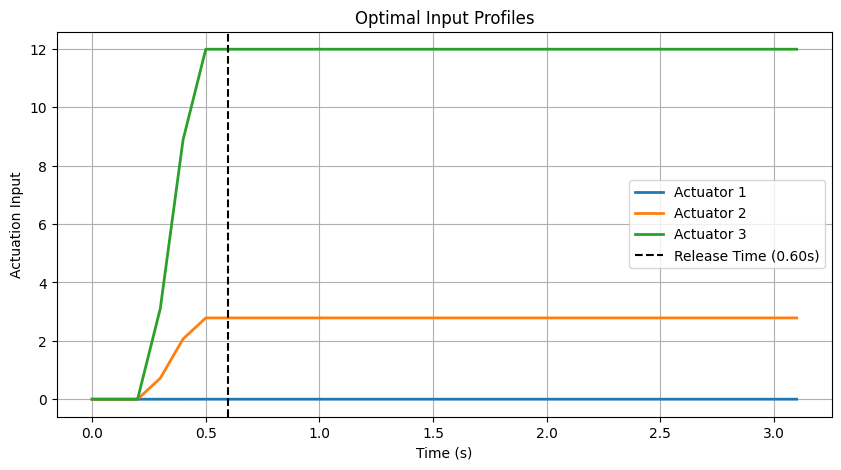

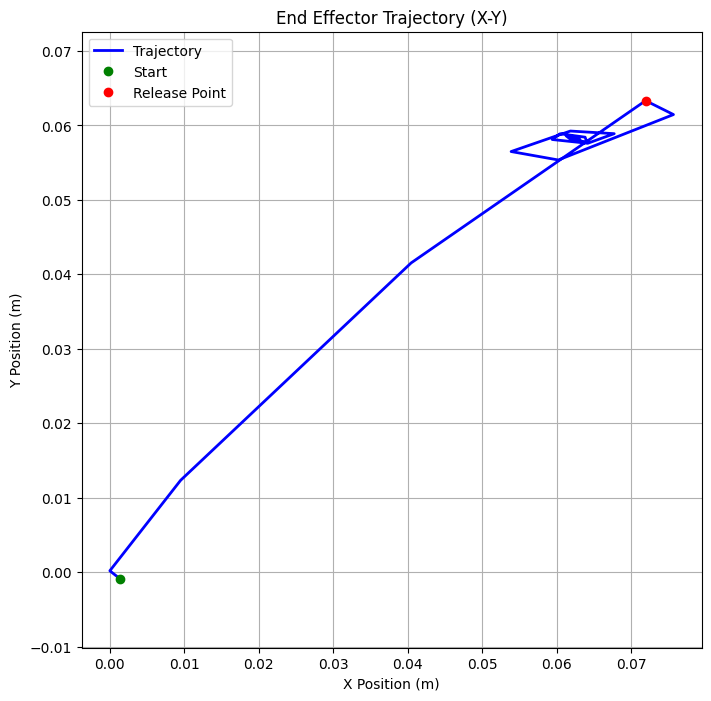

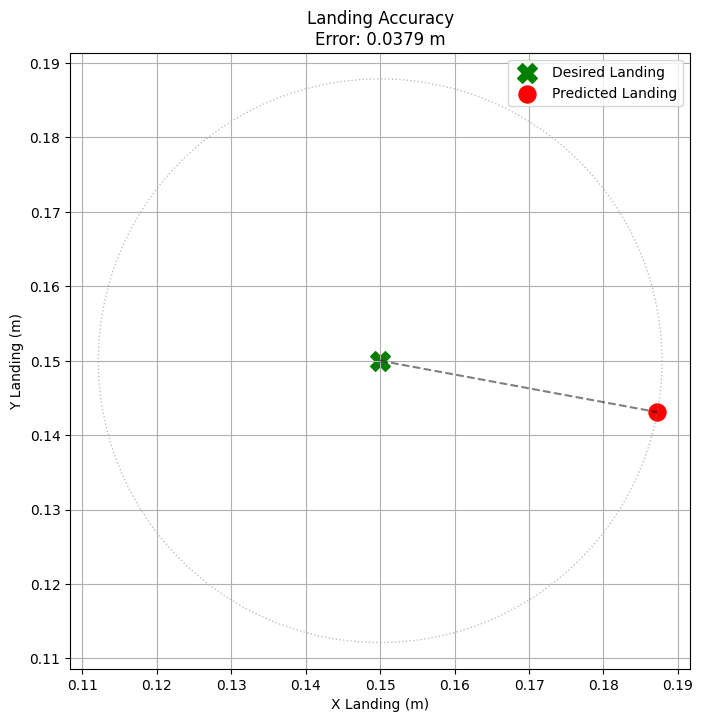

In [22]:
# %% [markdown]
# ### Optimization Results and Visualization

# %%
import matplotlib.patches as patches

# 1. Extract Best Parameters
best_params = study.best_params
print("Best Parameters Found:")
for key, value in best_params.items():
    print(f"  {key}: {value:.4f}")

print(f"\nBest Objective Value (Cost): {study.best_value:.4f}")

# 2. Re-run Simulation with Best Parameters to get Data
# We basically copy the logic from inside 'objective' but return data instead of cost

def run_best_simulation(params):
    # Unpack params
    u1_step = params["act1_step"]
    u2_step = params["act2_step"]
    u3_step = params["act3_step"]
    u_step = np.array([u1_step, u2_step, u3_step])
    
    t_smoothstep = params["t_smoothstep"]
    t_release = params["t_release"]
    
    # --- RECREATE INPUT ARRAY (Same logic as objective) ---
    total_steps = int(tmax / dt)
    ramp_steps = round(t_smoothstep / dt)
    if ramp_steps < 1: ramp_steps = 1
    
    release_steps = round(t_release/dt)
    
    smoothstep_factor = np.zeros((ramp_steps, 3))
    for i in range(ramp_steps):
        if ramp_steps > 1:
            x_val = (i - 0) / ((ramp_steps - 1) - 0)
        else:
            x_val = 1.0
        smoothstep_factor[i, :] = x_val * x_val * (3 - 2 * x_val)
        
    u_ramp = smoothstep_factor * u_step
    hold_steps = total_steps - ramp_steps
    if hold_steps > 0:
        u_hold = np.tile(u_step, (hold_steps, 1))
        u_array = np.vstack((u_ramp, u_hold))
    else:
        u_array = u_ramp[:total_steps]
        
    # Stack zeros for lag
    max_lag = max(lag_input, lag_state)
    zeros = np.zeros((max_lag+1, 3))
    u_array_with_lag = np.vstack((zeros, u_array))

    # Scaling
    u_array_scaled = input_scaler.transform(u_array_with_lag)
    # Ensure correct device
    u_array_torch = torch.from_numpy(u_array_scaled).type(torch.float32).to(device)
    
    X_init = state_scaler.transform(X)
    X_init_scaled = torch.from_numpy(X_init).type(torch.float32).to(device)

    # --- ROLLOUT ---
    current_state = X_init_scaled[max_lag,:]
    if lag_state == 0: past_state = X_init_scaled[max_lag:max_lag]
    else: 
        past_state = X_init_scaled[max_lag-lag_state:max_lag,:]
        past_state = torch.flatten(input=past_state)
        
    current_input = u_array_torch[max_lag,:]
    if lag_input == 0: past_input = u_array_torch[max_lag:max_lag,:]
    else:
        past_input = u_array_torch[max_lag-lag_input:max_lag,:]
        past_input = torch.flatten(input=past_input)
        
    # Feature joining logic
    if past_state.size(0) == 0 and past_input.size(0) == 0:
        joined_features = torch.cat((current_state, current_input), dim=0)
    elif past_state.size(0) != 0 and past_input.size(0) == 0:
        joined_features = torch.cat((current_state, past_state, current_input), dim=0)
    elif past_state.size(0) == 0 and past_input.size(0) != 0:
        joined_features = torch.cat((current_state, current_input, past_input), dim=0)
    else:
        joined_features = torch.cat((current_state, past_state, current_input, past_input), dim=0)

    preds = []
    # Buffer on device
    X_buffer = torch.zeros(max_lag+1+len(u_array_torch), 6).to(device)
    for i in range(max_lag+1):
        X_buffer[i,:] = X_init_scaled[i,:]

    with torch.inference_mode():
        for i in range(max_lag+1, len(u_array_torch)):
            pred = forward_model(joined_features.unsqueeze(0)).squeeze(0)
            preds.append(pred)
            X_buffer[i,:] = pred
            
            # Buffer update logic
            current_state = pred
            if lag_state == 0: past_state = X_buffer[i:i]
            else: 
                past_state = X_buffer[i-lag_state:i,:]
                past_state = torch.flatten(input=past_state)
            
            current_input = u_array_torch[i,:]
            if lag_input == 0: past_input = u_array_torch[i:i,:]
            else:
                past_input = u_array_torch[i-lag_input:i,:]
                past_input = torch.flatten(input=past_input)

            if past_state.size(0) == 0 and past_input.size(0) == 0:
                joined_features = torch.cat((current_state, current_input), dim=0)
            elif past_state.size(0) != 0 and past_input.size(0) == 0:
                joined_features = torch.cat((current_state, past_state, current_input), dim=0)
            elif past_state.size(0) == 0 and past_input.size(0) != 0:
                joined_features = torch.cat((current_state, current_input, past_input), dim=0)
            else:
                joined_features = torch.cat((current_state, past_state, current_input, past_input), dim=0)

    # Post-processing
    preds_tensor = torch.stack(preds, dim=0).cpu() # Move back to CPU for numpy processing
    preds_np = preds_tensor.numpy()
    preds_np = state_scaler.inverse_transform(preds_np)
    
    # Calculate Landing
    diff = np.diff(preds_np, axis=0)
    velocities = np.vstack([np.zeros((1, 6)), diff / dt])
    
    delta_z = preds_np[:, -1] - z_g
    sqrt_term = velocities[:,-1]**2 + (2 * g * delta_z)
    # Avoid negative sqrt warning if any
    sqrt_term[sqrt_term < 0] = 0 
    t_flight = (velocities[:,-1] + np.sqrt(sqrt_term)) / g
    x_landing = preds_np[:,3] + velocities[:,3] * t_flight
    y_landing = preds_np[:,4] + velocities[:,4] * t_flight
    
    # Get specific landing point
    idx = min(release_steps, len(x_landing) - 1)
    act_landing = np.array([x_landing[idx], y_landing[idx]])
    
    # Return everything needed for plotting
    return u_array_with_lag, preds_np, act_landing, idx

# Run the simulation
u_data, x_data, final_land_pos, release_idx = run_best_simulation(best_params)

# Time vectors for plotting
time_steps = np.arange(len(x_data)) * dt
time_inputs = np.arange(len(u_data)) * dt

# %% [markdown]
# ### Plots

# %%
# Plot 1: Actuation Profiles
plt.figure(figsize=(10, 5))
plt.plot(time_inputs, u_data[:, 0], label='Actuator 1', linewidth=2)
plt.plot(time_inputs, u_data[:, 1], label='Actuator 2', linewidth=2)
plt.plot(time_inputs, u_data[:, 2], label='Actuator 3', linewidth=2)
# Add vertical line for release time
# Note: release_idx corresponds to preds, we need to shift it for inputs which has lag padding
max_lag = max(lag_input, lag_state)
release_time_plot = (release_idx + max_lag + 1) * dt
plt.axvline(x=release_time_plot, color='k', linestyle='--', label=f'Release Time ({release_time_plot:.2f}s)')
plt.title('Optimal Input Profiles')
plt.xlabel('Time (s)')
plt.ylabel('Actuation Input')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: 2D End Effector Trajectory (X-Y)
plt.figure(figsize=(8, 8))
plt.plot(x_data[:, 3], x_data[:, 4], 'b-', linewidth=2, label='Trajectory')
# Mark start
plt.plot(x_data[0, 3], x_data[0, 4], 'go', label='Start')
# Mark release point
plt.plot(x_data[release_idx, 3], x_data[release_idx, 4], 'ro', label='Release Point')
plt.title('End Effector Trajectory (X-Y)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Plot 3: Landing Targets
plt.figure(figsize=(8, 8))
# Plot Desired
plt.scatter(des_land_pos[0], des_land_pos[1], color='green', s=200, marker='X', label='Desired Landing')
# Plot Actual
plt.scatter(final_land_pos[0], final_land_pos[1], color='red', s=150, marker='o', label='Predicted Landing')
# Draw line connecting them
plt.plot([des_land_pos[0], final_land_pos[0]], [des_land_pos[1], final_land_pos[1]], 'k--', alpha=0.5)

# Add circles for visual context (distance error)
error = np.linalg.norm(final_land_pos - des_land_pos)
circle = plt.Circle(des_land_pos, error, color='gray', fill=False, linestyle=':', alpha=0.5)
plt.gca().add_patch(circle)

plt.title(f'Landing Accuracy\nError: {error:.4f} m')
plt.xlabel('X Landing (m)')
plt.ylabel('Y Landing (m)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()